In [1]:
%env OPENAI_API_KEY=yur_key


env: OPENAI_API_KEY=yur_key


## Tweet Sentiment Extraction



[https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview](https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview)

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

import re
import os
import random

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

%matplotlib inline

!pip install --upgrade openai


In [81]:
test = pd.read_csv('./data/test.csv')

#test = test.head(10)

test.head(5)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [83]:
test.groupby(['sentiment']).size().reset_index(name='counts')

,sentiment,counts
0,negative,1001
1,neutral,1430
2,positive,1103


## (Non Fine-Tuned) OpenAI Inference 
This inference is direct api call with non custom / fine tuned model

In [7]:
import openai

def predict(p, model_name, max_tokens):
    response =  openai.Completion.create(
        model=model_name,
        # model="text-davinci-003",
        prompt=p,
        temperature=0,
        max_tokens=max_tokens,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
        #logprobs=3
    )
    
    return response.choices[0].text.lower().strip()


def make_prompt(text):
    return f'Classify the sentiment of this tweet as positive or negative or neutral:\n\n' + f'1. \"{text}\"\n\n### \n\n'



def predict_batch(df, model_name, batch_size=1, max_tokens=10):
    row_num = df.shape[0]
    #batch_size=4 # looks like the api only respond 4 tweets at a time
    print_i = 500
    all_predictions = []

    for i in range(1, row_num + 1):

        #if (i-1) % batch_size == 0:
            #p = f'Classify the sentiment each in these tweets as positive or negative or neutral:\n\n'
            #p = f'Classify the sentiment in this tweet:\n\n\"{tweet}\"\n\n###\n\n '
        #    p = f'Classify the sentiment of this tweet as positive or negative or neutral:\n\n'


        text = df.at[i-1, 'text']
        prompt = make_prompt(text)
        #p = p + f'1. \"{text}\"\n\n### \n\n'

        #if i % batch_size == 0 or i == row_num:
        prediction = predict(prompt, model_name, max_tokens)
        prediction_clean = re.findall(r'positive|negative|neutral', prediction)
        #print(f'prediction_clean: {prediction_clean}')
        assert (prediction_clean[0] == 'positive' or prediction_clean[0] ==  'negative' or prediction_clean[0] ==  'neutral')

        all_predictions.append(prediction_clean[0])
        #print(f'prompt: {prompt}, prediction: {prediction}')

        if i % print_i == 0 or i == row_num:
            print(f'predicts {i} of {row_num}')
            
        assert i == len(all_predictions)
 

        
    print(f'row_num: {row_num}, all_predictions: {len(all_predictions)}') 

    assert row_num == len(all_predictions)
    
    return all_predictions


In [95]:
test_predictions = predict_batch(test, 'text-davinci-003') # use built-in model
test['prediction'] = np.array(test_predictions)
test['correct_prediction'] = test['sentiment'] == test['prediction']

test_accuracy = test[test['sentiment'] == test['prediction']].shape[0] / test.shape[0]

print(f'test_accuracy: {test_accuracy}')

test.groupby(['correct_prediction','sentiment','prediction']).size().reset_index(name='counts')

predicts 500 of 3534
predicts 1000 of 3534
predicts 1500 of 3534
predicts 2000 of 3534
predicts 2500 of 3534
predicts 3000 of 3534
predicts 3500 of 3534
predicts 3534 of 3534
row_num: 3534, all_predictions: 3534
test_accuracy: 0.6295981890209394


,correct_prediction,sentiment,prediction,counts
0,False,negative,neutral,558
1,False,negative,positive,64
2,False,neutral,negative,66
3,False,neutral,positive,280
4,False,positive,negative,7
5,False,positive,neutral,334
6,True,negative,negative,379
7,True,neutral,neutral,1084
8,True,positive,positive,762


## (Fine-Tuned) OpenAI Inference 

In [96]:
train = pd.read_csv('./data/train.csv')

#train = train.head(1000)

train.groupby(['sentiment']).count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11118,11117,11117
positive,8582,8582,8582


In [97]:
train = train.rename(columns={"text": "prompt", "sentiment": "completion"})

train['prompt'] = train.apply(lambda x: make_prompt(x['prompt']), axis=1)

train[['prompt', 'completion']].to_json("train.jsonl", orient='records', lines=True)

train.head(5)

,textID,prompt,selected_text,completion
0,cb774db0d1,"Classify the sentiment of this tweet as positive or negative or neutral:\n\n1. "" I`d have responded, if I were going""\n\n### \n\n","I`d have responded, if I were going",neutral
1,549e992a42,"Classify the sentiment of this tweet as positive or negative or neutral:\n\n1. "" Sooo SAD I will miss you here in San Diego!!!""\n\n### \n\n",Sooo SAD,negative
2,088c60f138,"Classify the sentiment of this tweet as positive or negative or neutral:\n\n1. ""my boss is bullying me...""\n\n### \n\n",bullying me,negative
3,9642c003ef,"Classify the sentiment of this tweet as positive or negative or neutral:\n\n1. "" what interview! leave me alone""\n\n### \n\n",leave me alone,negative
4,358bd9e861,"Classify the sentiment of this tweet as positive or negative or neutral:\n\n1. "" Sons of ****, why couldn`t they put them on the releases we already bought""\n\n### \n\n","Sons of ****,",negative


In [98]:
!openai tools fine_tunes.prepare_data -f train.jsonl -q

Analyzing...

- Your file contains 27481 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `"\n\n### \n\n`
- All prompts start with prefix `Classify the sentiment of this tweet as positive or negative or neutral:

1. "`. Fine-tuning doesn't require the instruction specifying the task, or a few-shot example scenario. Most of the time you should only add the input data into the prompt, and the desired output into the completion
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more details

Based on the analys

## Run below steps manually due to lengthy process 

export OPENAI_API_KEY=yur_key <br />
openai api fine_tunes.create -t "train_prepared_train.jsonl" -v "train_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes 3  -m davinci <br />

### Dump the train stats (mind your process name) 
openai api fine_tunes.results -i  ft-K0C1hn9yj0GLOu9g1hspL2zw > result.csv  <br />

### Test your model (mind your model name) 
openai api completions.create -m davinci:ft-personal-2023-03-13-03-23-53 -p YOUR_PROMPT <br />



<AxesSubplot: >

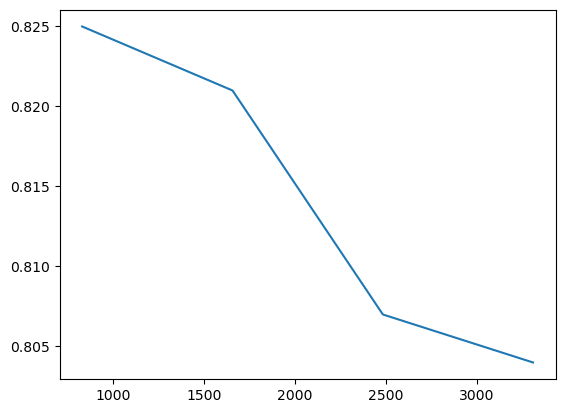

In [4]:
train_results = pd.read_csv('result.csv')
train_results[train_results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

# train_results[train_results['classification/accuracy'].notnull()].tail(1)

In [5]:
test = pd.read_csv('./data/test.csv')

#test = test.head(500)

test.groupby(['sentiment']).count()

,textID,text
sentiment,,
negative,1001,1001
neutral,1430,1430
positive,1103,1103


In [9]:
model_name = 'davinci:ft-personal-2023-03-13-03-23-53' # mind your model name

predictions = predict_batch(test, model_name, batch_size=1, max_tokens=1)

test['prediction'] = np.array(predictions)
test['correct_prediction'] = test['sentiment'] == test['prediction']

test_accuracy = test[test['sentiment'] == test['prediction']].shape[0] / test.shape[0]

print(f'test_accuracy: {test_accuracy}')

test.groupby(['correct_prediction','sentiment','prediction']).size().reset_index(name='counts')

predicts 500 of 3534
predicts 1000 of 3534
predicts 1500 of 3534
predicts 2000 of 3534
predicts 2500 of 3534
predicts 3000 of 3534
predicts 3500 of 3534
predicts 3534 of 3534
row_num: 3534, all_predictions: 3534
test_accuracy: 0.766553480475382


,correct_prediction,sentiment,prediction,counts
0,False,negative,neutral,362
1,False,negative,positive,13
2,False,neutral,negative,88
3,False,neutral,positive,122
4,False,positive,negative,6
5,False,positive,neutral,234
6,True,negative,negative,626
7,True,neutral,neutral,1220
8,True,positive,positive,863
